# Classification of the MNIST dataset

# 1. Introduction

This notebook will demonstrate how to train a neural network to recognize images of handwritten digits using TensorFlow.  While there are many [MNIST](http://yann.lecun.com/exdb/mnist/) computer vision tutorials that cover the basics, this guide will focus on developing a self contained model that can handle preprocessing.  
The contents of this notebook include: 
* Data exploration
* Data preprocessing
* Building a Convolutional Neural Network
* Model training
* Evaluation of results
* Predicting outcomes with test data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


### 1.1 Import libraries and verify versions

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from platform import python_version

print('Tensorflow Version:', tf.__version__)
print('Python Version:', python_version())

Tensorflow Version: 2.4.1
Python Version: 3.7.10


### 1.2 Load the training .csv file and explore the data

In [3]:
path = '../input/digit-recognizer/train.csv'
df = pd.read_csv(path)

print(df.shape)
df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Configure random state
RANDOM_SEED = 123

### 1.3 Isolate the label column from the pixel data.

In [5]:
y_labels = df.pop('label')
x_pixels = df

### 1.4 Review the labels to confirm the number of unique values.

In [6]:
unique_labels = np.unique(y_labels)
NUM_LABELS = (len(unique_labels))
print("Labels: ", unique_labels)
print("No. Labels: ", NUM_LABELS)

Labels:  [0 1 2 3 4 5 6 7 8 9]
No. Labels:  10


The training data has 42,000 images.  Let's examine one of them. 

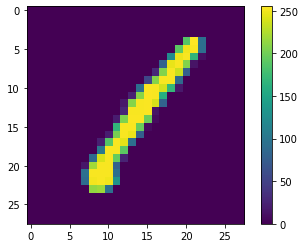

In [7]:
plt.figure()
# Reshape the array to 28x28 dimensions
plt.imshow(np.array(x_pixels.iloc[0]).reshape(28, 28)) 
plt.colorbar()
plt.show()

The colorbar shows the pixel values are within the grayscale range of 0 to 255.  These values will need to be scaled to a range of 0 to 1 which will be covered later in this guide.
Let's visualize some more images, this time matched with their labels.   

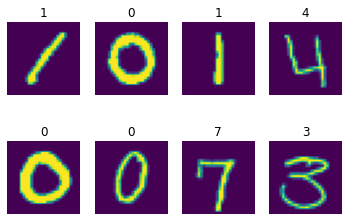

In [8]:
plt.figure()
for i in range(8): 
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(np.array(x_pixels.iloc[i]).reshape(28, 28))
    plt.title(y_labels[i])
    plt.axis('off')

With the data verified, it's time to create Datasets for training and validation.

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_pixels, y_labels, test_size=0.2, random_state=RANDOM_SEED)

For this split 80% of the images will be used for training, and 20% for validation.

In [10]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(33600, 784)
(8400, 784)
(33600,)
(8400,)


# 2. Create Datasets from the training and validation data
The Dataset object is a Python iterable that can be configured for improved performance.  Datasets are used to build efficient input pipelines in TensorFlow.

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

### 2.1 The following code shows 4 different Dataset methods:
* *Cache()*: Keeps the Dataset elements in memory to be used in later iterations.  
* *Shuffle()*: Randomly shuffles the elements of the Dataset so each batch can reflect the overall distribution.  This reduces overfitting and variance when training.
* *Batch()*: Packs the elements of the Dataset into batches.  This determines the number of samples processed during an iteration. 
* *Prefetch()*: Reduces time by overlapping data preprocessing and model execution of a training step.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = 1000 # Shuffle buffer
BATCH_SIZE = 32

def configure_dataset(dataset, shuffle=False, test=False):
    # Configure the tf dataset for cache, shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.cache()\
                        .shuffle(BUFFER_SIZE, seed=RANDOM_SEED, reshuffle_each_iteration=True)\
                        .batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    elif test:
        dataset = dataset.cache()\
                        .batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)
    else:
        dataset = dataset.cache()\
                        .batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return dataset

In [13]:
train_ds = configure_dataset(train_ds, shuffle=True)
val_ds = configure_dataset(val_ds)

Observe the shape of the training and validation Datasets.  This is the batch size (128) and number of pixel columns (784).

In [14]:
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(32, 784), dtype=tf.int64, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))
(TensorSpec(shape=(32, 784), dtype=tf.int64, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))


# 3. Build a sequential CNN with preprocessing layers

The reshaping and rescaling tasks are included in the model.  These preprocessing layers can then be saved and exported with the CNN.  This is the preferred approach only if you're training on a GPU. 

A CNN requires image dimensions and a color channel to function.  Here inputs are reshaped to include the grayscale color channel.  

Inputs need to be normalized to a range of 0 to 1.  Divide the pixel values by 255 to achieve this scale.  Insert this layer after reshaping. 

In this example two convolutional layers are used, each with batch normalization, max pooling, and a dropout layer. A final classification layer is added with units the size of the number of classes.

In [15]:
# Reshape to (height, width, color channel)
reshape_layer = layers.Reshape((28, 28, 1))
# Include the decimal point when dividing to output floats 
rescale_layer = layers.experimental.preprocessing.Rescaling(scale=1./255)

model = Sequential([
                    layers.InputLayer(input_shape=[28, 28]),
                    reshape_layer,
                    rescale_layer,
                    layers.Conv2D(128, kernel_size=3, activation='relu'),                                                 
                    layers.BatchNormalization(), # Normalizes layer activations                     
                    layers.MaxPooling2D(2,2), # Downsamples the feature map                    
                    layers.Dropout(0.5), # Reduces overfitting
                    layers.Conv2D(128, kernel_size=3, activation='relu'),
                    layers.BatchNormalization(),
                    layers.MaxPooling2D(2,2),
                    layers.Dropout(0.5), 
                    layers.Flatten(),  
                    layers.Dense(NUM_LABELS, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       1

# 4. Train the CNN model 
Sparse categorical crossentropy is used as the loss function with Adam as the optimizer.

In [16]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(lr=1e-3),
    metrics=['accuracy']
)

EPOCHS = 20

history = model.fit(
    train_ds,
    epochs=EPOCHS, 
    validation_data=val_ds
)

Epoch 1/20
1050/1050 [==============================] - 12s 5ms/step - loss: 0.6756 - accuracy: 0.8364 - val_loss: 0.1013 - val_accuracy: 0.9745
Epoch 2/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1614 - accuracy: 0.9629 - val_loss: 0.0957 - val_accuracy: 0.9745
Epoch 3/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1337 - accuracy: 0.9694 - val_loss: 0.0818 - val_accuracy: 0.9821
Epoch 4/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1156 - accuracy: 0.9738 - val_loss: 0.0706 - val_accuracy: 0.9851
Epoch 5/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1008 - accuracy: 0.9780 - val_loss: 0.0656 - val_accuracy: 0.9856
Epoch 6/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0956 - accuracy: 0.9776 - val_loss: 0.0554 - val_accuracy: 0.9868
Epoch 7/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0826 - accuracy: 0.9812 - val_loss: 0.0555 - val_accuracy

# 5. Visualize and evaluate the training and validation results

In [17]:
# Assign the loss and accuracy metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [18]:
# Create a function to plot the metrics
def plot_history(train_history, val_history, label):
    plt.plot(train_history, label=f'Training {label}')
    plt.plot(val_history, label=f'Validation {label}')
    plt.xlabel('Epochs')
    plt.legend()
    return plt.show()

The training and validation plots should converge for optimal results.

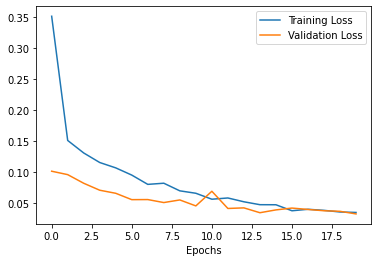

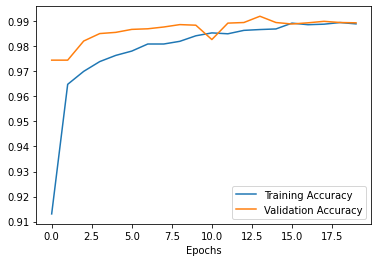

In [19]:
plot_history(train_loss, val_loss, 'Loss')
plot_history(train_acc, val_acc, 'Accuracy')

# 6. Create a Dataset from the test data

### 6.1 Load the test .csv file 

In [20]:
path_test = '../input/digit-recognizer/test.csv'
df_test = pd.read_csv(path_test)
print(df_test.shape)
df_test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
test_ds = tf.data.Dataset.from_tensor_slices((df_test))
test_ds = configure_dataset(test_ds, test=True) # Set test argument to True so that remainder samples are not dropped
test_ds.element_spec

TensorSpec(shape=(None, 784), dtype=tf.int64, name=None)

# 7. Predict label outcomes and submit results

In [22]:
y_pred = np.argmax(model.predict(test_ds), axis=-1) # Returns the highest probability label for each image
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Label']
print(y_pred.shape)
y_pred.head()


(28000, 1)


,Label
0,2
1,0
2,9
3,9
4,3


In [23]:
image_id = pd.DataFrame(y_pred.index + 1)
image_id.columns = ['ImageId']
image_id.head()

,ImageId
0,1
1,2
2,3
3,4
4,5


In [24]:
submission = pd.concat([image_id, y_pred], axis=1)
submission.to_csv('submission.csv', index=False)